In [1]:
import pandas as pd
import os
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
BASE_PATH = r'c:\Users\dv987\Documents\GitHub\Sample'
# Replace BASE_PATH with your own path to this folder.

In [2]:
def load_bls(name):
    """Load and clean employment data from the Federal Bureau of Labor
    Statistics.

    Keyword arguments:
    name -- the name of the xlsx file
    """
    df = pd.read_excel(os.path.join(BASE_PATH, name), 
                       skiprows=2, skipfooter=5, na_values=['(n)'])
    df = df.drop([0])
    # The first row after headers is empy so we drop it.
    df = df.drop(['LAUS Code','ST FIPS Code', 'Civilian Labor Force',
                  'Unemployment'], axis=1)
    df = df.rename(columns={'Area':'MSA', 'Area FIPS Code':'FIPS Code'})
    df = df.dropna(how='all')
    # We'll later be merging this dataframe with one that measures time
    # in years. To solve this, we'll agreggate this data by year now by
    # averaging months together.
    df_aggregated = df.drop('Month', axis=1).groupby(['MSA', 'Year']) \
        .mean().reset_index()
    return df_aggregated
MSA_employment = load_bls('ssamatab1.xlsx')
MSA_employment.head()

,MSA,Year,FIPS Code,Employment,Unemployment Rate
0,"Abilene, TX MSA",1990.0,10180.0,64433.583333,5.950000
1,"Abilene, TX MSA",1991.0,10180.0,65679.000000,5.325000
2,"Abilene, TX MSA",1992.0,10180.0,67115.083333,5.525000
3,"Abilene, TX MSA",1993.0,10180.0,68664.250000,5.408333
4,"Abilene, TX MSA",1994.0,10180.0,70252.583333,4.958333


In [3]:
def load_bea():
    """ Load and clean manufacturing employment data from the Bureau of
    Economic Analysis using its API.
    """
    userid = '6633B66D-A212-4FF2-B8AE-46E60688BD22'
    method = 'GetData'
    dataset = 'Regional'
    results = 'json'
    # These parameters indicate the dataset we want and the format of
    # the data.
    tablename = 'CAEMP25N'
    linecode = '500'
    geofips = 'MSA'
    year = 'ALL'
    # These dataset-specific parameters indicate which table and column
    # we retrieve, and the geographic resolution of the data. 
    url = (f'https://apps.bea.gov/api/data/?UserID={userid} \
    &method={method}&datasetname={dataset}&TableName={tablename} \
    &LineCode={linecode}&GeoFips={geofips}&Year={year} \
    &ResultFormat={results}')
    response = requests.get(url).json()
    df = pd.json_normalize(response['BEAAPI']['Results']['Data'])
    df.to_csv('nipa_T10101.csv', index=False)
    df = df.drop(['Code', 'UNIT_MULT', 'NoteRef', 'CL_UNIT'], axis=1)
    df = df.rename(columns={'GeoName':'MSA', 'GeoFips':'FIPS Code',
                            'TimePeriod':'Year',
                            'DataValue':'Manufacturing Jobs'})
    cols = ['FIPS Code', 'Year', 'Manufacturing Jobs']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    # We'll this data to be integers rather than strings to properly
    # manipulate it later on.
    return df
MSA_manufacturing = load_bea()
MSA_manufacturing.head()

,FIPS Code,MSA,Year,Manufacturing Jobs
0,998,United States (Metropolitan Portion),2001,13722906
1,998,United States (Metropolitan Portion),2002,12728492
2,998,United States (Metropolitan Portion),2003,12080129
3,998,United States (Metropolitan Portion),2004,11906135
4,998,United States (Metropolitan Portion),2005,11838580


In [5]:
# Now that both datasets are loaded and cleaned, we can merge them by
# FIPS code.
def merge_bls_bea(df1, df2):
    """Merge the BLS and BEA dataframes.
    
    Keyword Arguments:
    df1 -- the dataframe containing the bls employment data
    df2 -- the dataframe containing the bea manufacturing jobs data
    """
    df_merged = df1.merge(df2, on=('FIPS Code', 'Year'), how='inner',
                          indicator=True)
    df_merged = df_merged.drop(['MSA_y', '_merge'], axis=1)
    df_merged = df_merged.rename(columns={'MSA_x':'MSA'})
    return df_merged
MSA_complete = merge_bls_bea(MSA_employment, MSA_manufacturing)
MSA_complete.head()

,MSA,Year,FIPS Code,Employment,Unemployment Rate,Manufacturing Jobs
0,"Abilene, TX MSA",2001.0,10180.0,72030.083333,4.458333,3593
1,"Abilene, TX MSA",2002.0,10180.0,73736.583333,5.066667,3479
2,"Abilene, TX MSA",2003.0,10180.0,75280.833333,5.350000,3163
3,"Abilene, TX MSA",2004.0,10180.0,75845.250000,4.716667,3385
4,"Abilene, TX MSA",2005.0,10180.0,77011.083333,4.266667,3478


In [6]:
# We're interested in uncovering the relationship between an MSA's
# portion of jobs in manufacturing pre-recession (2007) and its overall
# change in unemployment during the recession (2007 to 2009).
def clean_merged(df):
    """Clean merged BLS and BEA data and prepare it for analysis.

    Keyword arguments:
    df -- the merged BLS and BEA dataframe
    """
    # Let's add a column telling us the percentage of jobs in each MSA
    # in manufacturing.
    df['MANU_PER'] = 100*df['Manufacturing Jobs']/df['Employment']
    # And now we'll find the change in unemployment between 2001 and
    # 2022 in each MSA.
    MSA_2007 = df[df.Year == 2007].copy().drop('Year', axis=1)
    MSA_2009 = df[df.Year == 2009].copy().drop(['Employment',
                                                'Manufacturing Jobs',
                                                'MANU_PER', 'Year',
                                                'MSA'], axis=1)
    MSA_difference = MSA_2007.merge(MSA_2009, on = 'FIPS Code')
    MSA_difference['UNEMP_CHG'] = (MSA_difference['Unemployment Rate_y']
                                   - MSA_difference
                                   ['Unemployment Rate_x'])
    return MSA_difference.drop(['Unemployment Rate_y',
                                'Unemployment Rate_x', 'Employment',
                                'Manufacturing Jobs'], axis=1)
MSA_cleaned = clean_merged(MSA_complete)
MSA_cleaned.head()

,MSA,FIPS Code,MANU_PER,UNEMP_CHG
0,"Abilene, TX MSA",10180.0,4.661842,2.175000
1,"Akron, OH MSA",10420.0,13.211973,4.658333
2,"Albany, GA MSA",10500.0,9.673686,4.608333
3,"Albany, OR MSA",10540.0,17.232000,7.058333
4,"Albany-Schenectady-Troy, NY MSA",10580.0,0.000000,3.116667


                            OLS Regression Results                            
Dep. Variable:              UNEMP_CHG   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     33.84
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           1.31e-08
Time:                        13:03:46   Log-Likelihood:                -716.04
No. Observations:                 366   AIC:                             1436.
Df Residuals:                     364   BIC:                             1444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7521      0.155     24.245      0.0

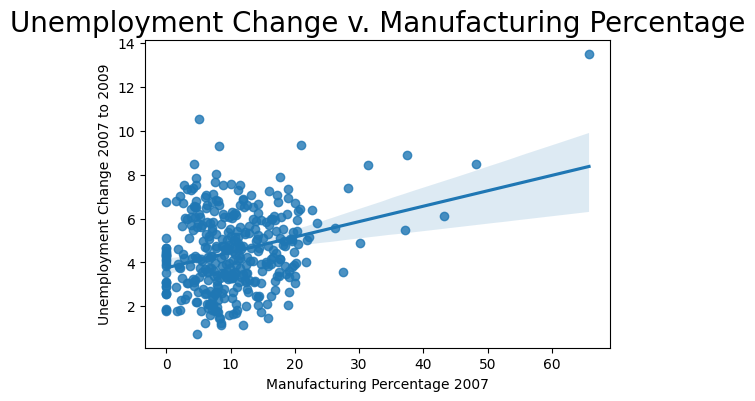

In [9]:
# Now we have a dataframe telling us each MSA's percentage of
# manufacturing jobs in 2007 and its change in unemployment between 2007
# and 2009. Let's see what that data tells us.
def unemp_manu_reg(df):
   """Regress and plot unemployment change against manufactruing
   percentage.

   Keyword arguments:
   df - the dataset to conduct the regression with
   """
   regression = smf.ols('UNEMP_CHG ~ MANU_PER', data=df).fit()
   print(regression.summary())
   fig, ax = plt.subplots(figsize=(6, 4))
   sns.regplot(x='MANU_PER', y='UNEMP_CHG', data=df, ax=ax)
   ax.set_xlabel('Manufacturing Percentage 2007', fontsize=10)
   ax.set_ylabel('Unemployment Change 2007 to 2009', fontsize=10)
   ax.set_title('Unemployment Change v. Manufacturing Percentage',
                fontsize=20)
unemp_manu_reg(MSA_cleaned)

In [8]:
# We see a p-value of less than 0.001, implying a high certainty of
# correlation between the two variables. See the README file for further
# analysis.